# 1. Thư viện

## 1.1. Khai báo các thư viện

In [1]:
#importing necessary modules
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns
import joblib

import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

import xgboost
from xgboost import XGBRegressor

## 1.2. Kiểm tra phiên bản các thư viện

In [2]:
#python package version information
print('Python version:{}'.format(sys.version))
print('Numpy version:{}'.format(np.__version__))
print('Pandas version:{}'.format(pd.__version__))
print('MatlpotLib version:{}'.format(matplotlib.__version__))
print('Seaborn version:{}'.format(sns.__version__))
print('Sci-Kit Learn version:{}'.format(sklearn.__version__))
print('XGBoost version:{}'.format(xgboost.__version__))

Python version:3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
Numpy version:2.3.1
Pandas version:2.3.0
MatlpotLib version:3.10.3
Seaborn version:0.13.2
Sci-Kit Learn version:1.7.0
XGBoost version:3.0.2


# 2. Thu thập và xử lý dữ liệu

## 2.1 Lấy dữ liệu

### 2.1.1 Dữ liệu từ file

#### 2.1.1.1 Drive

In [3]:
# from google.colab import drive
# import pandas as pd

# # Mount Google Drive
# drive.mount('/content/drive')

# # Đặt đường dẫn tới thư mục chứa dữ liệu
# data_path = '/content/drive/MyDrive/MHUD/Project/Datasets'

# # Đọc file CSV từ Google Drive như đọc local
# eu = pd.read_csv(f'{data_path}/EURUSD-2000-2020-15m.csv', skipinitialspace=True)

# # Chuẩn hóa cột
# eu.columns = [x.lower() for x in eu.columns]

# # Chuyển đổi cột thời gian
# eu["date_time"] = pd.to_datetime(eu["date_time"], format='%Y.%m.%d %H:%M:%S')
# eu.set_index('date_time', inplace=True)

# # Hiển thị 5 dòng đầu tiên
# eu.head(5)


#### 2.1.1.2 Local

In [4]:
eu = pd.read_csv('./Datasets/EURUSD-2000-2020-15m.csv', skipinitialspace=True)
eu.columns = [x.lower() for x in eu.columns]
eu["date_time"] = pd.to_datetime(eu["date_time"], format='%Y.%m.%d %H:%M:%S')
eu.set_index('date_time', inplace=True)
eu.head(5)

,high,low,open,close
date_time,,,,
2000-01-03 00:00:00,1.0080,1.0073,1.0073,1.0077
2000-01-03 00:15:00,1.0087,1.0076,1.0078,1.0086
2000-01-03 00:30:00,1.0089,1.0079,1.0087,1.0079
2000-01-03 00:45:00,1.0132,1.0078,1.0078,1.0128
2000-01-03 01:00:00,1.0133,1.0120,1.0129,1.0122


### 2.1.2 Trực quan hóa dữ liệu

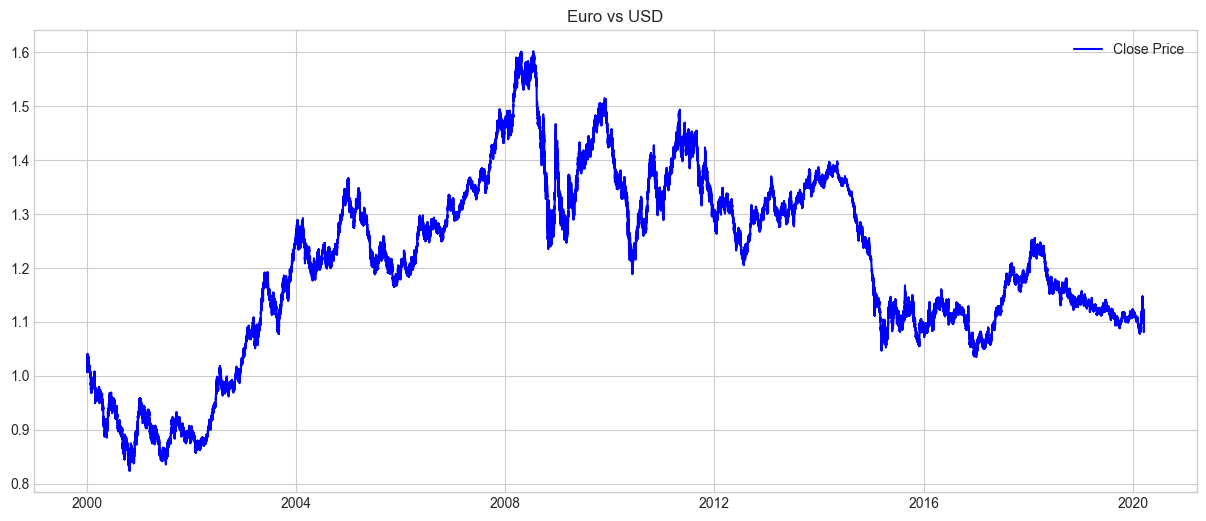

<Axes: >

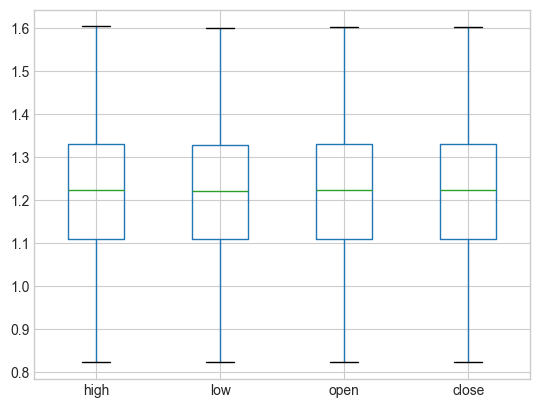

In [5]:
plt.figure(figsize=(15,6))
plt.plot(eu.close, label='Close Price', color='blue')
plt.title('Euro vs USD')
plt.legend()
plt.show()

#box plot for open, high, low , close
eu.boxplot()

### 2.1.3 Tạo các đặc trưng mới

In [6]:
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()

    # 6 original features
    df_new['open'] = df['open']
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)

    # 50 original features
    # average price
    df_new['avg_price_5'] = df['close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30'] = df['close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90'] = df['close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365'] = df['close'].rolling(window=252).mean().shift(1)

    # average price ratio
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_905_'] = df_new['avg_price_5'] / df_new['avg_price_90']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_90'] = df_new['avg_price_30'] / df_new['avg_price_90']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    df_new['ratio_avg_price_90_365'] = df_new['avg_price_90'] / df_new['avg_price_365']

    # standard deviation of prices
    df_new['std_price_5'] = df['close'].rolling(window=5).std().shift(1)
    df_new['std_price_30'] = df['close'].rolling(window=21).std().shift(1)
    df_new['std_price_90'] = df['close'].rolling(window=63).std().shift(1)
    df_new['std_price_365'] = df['close'].rolling(window=252).std().shift(1)

    # standard deviation ratio of prices
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_90'] = df_new['std_price_5'] / df_new['std_price_90']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_90'] = df_new['std_price_30'] / df_new['std_price_90']
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']
    df_new['ratio_std_price_90_365'] = df_new['std_price_90'] / df_new['std_price_365']

    # return
    df_new['return_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
    df_new['return_90'] = ((df['close'] - df['close'].shift(63)) / df['close'].shift(63)).shift(1)
    df_new['return_365'] = ((df['close'] - df['close'].shift(252)) / df['close'].shift(252)).shift(1)

    #average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=63).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(window=252).mean()

    # RSI (Relative Strength Index)
    for n in [7, 14, 21]:
        delta = df['close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        avg_gain = gain.rolling(window=n).mean().shift(1)
        avg_loss = loss.rolling(window=n).mean().shift(1)

        rs = avg_gain / avg_loss
        df_new[f'rsi_{n}'] = 100 - (100 / (1 + rs))

    # Stochastic Oscillator
    for n in [5, 14, 21]:
        low_n = df['low'].rolling(window=n).min().shift(1)
        high_n = df['high'].rolling(window=n).max().shift(1)

        # %K
        df_new[f'stoch_k_{n}'] = 100 * ((df['close'].shift(1) - low_n) / (high_n - low_n))
        # %D (Simple Moving Average of %K)
        df_new[f'stoch_d_{n}'] = df_new[f'stoch_k_{n}'].rolling(window=3).mean()

    # Bollinger Bands
    for n in [10, 20, 50]:
        # Middle Band
        middle_band = df['close'].rolling(window=n).mean().shift(1)
        # Standard Deviation
        std_dev = df['close'].rolling(window=n).std().shift(1)

        # Upper and Lower Bands
        df_new[f'bollinger_upper_{n}'] = middle_band + (std_dev * 2)
        df_new[f'bollinger_lower_{n}'] = middle_band - (std_dev * 2)

    # MACD
    # Standard Configuration (12, 26)
    ema_fast = df['close'].ewm(span=12, adjust=False).mean()
    ema_slow = df['close'].ewm(span=26, adjust=False).mean()
    df_new['macd_12_26'] = (ema_fast - ema_slow).shift(1)
    df_new['macd_signal_12_26'] = df_new['macd_12_26'].ewm(span=9, adjust=False).mean()

    # Alternative Configuration (5, 35)
    ema_fast_alt = df['close'].ewm(span=5, adjust=False).mean()
    ema_slow_alt = df['close'].ewm(span=35, adjust=False).mean()
    df_new['macd_5_35'] = (ema_fast_alt - ema_slow_alt).shift(1)
    df_new['macd_signal_5_35'] = df_new['macd_5_35'].ewm(span=5, adjust=False).mean()

    # the target
    df_new['close'] = df['close']
    df_new = df_new.dropna(axis=0)
    return df_new

data = generate_features(eu)

### 2.1.4 Kiểm tra dữ liệu đã sử lý


Heat map



<Axes: >

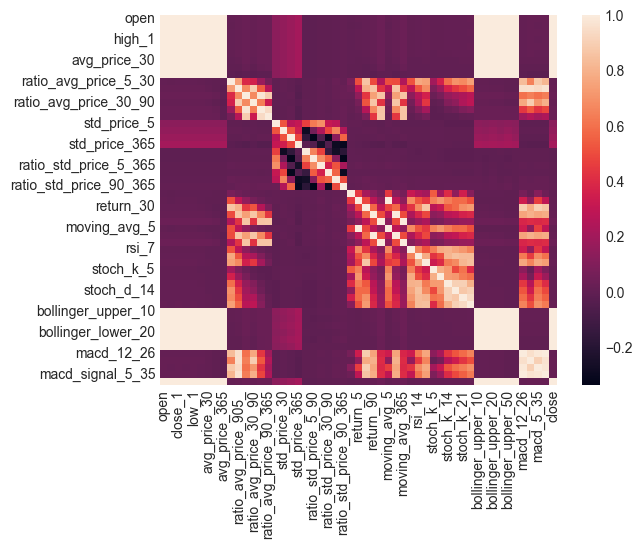

In [7]:
data.head()

data.describe()
print("\nHeat map\n")
sns.heatmap(data.corr())

## 2.2 Chia dữ liệu

### 2.2.1 fold-out

In [8]:
#import datetime module
import datetime

#segregate data for training
start_train = datetime.datetime(2000, 1, 1,0,0)
end_train = datetime.datetime(2018, 12, 31, 0, 0)
data_train = data.loc[start_train:end_train]
data_train.describe()


#segregate data for testing
start_test = datetime.datetime(2019, 1, 1, 0, 0)
data_test = data.loc[start_test:]
data_test.describe()

,open,open_1,close_1,high_1,low_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,...,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,bollinger_upper_50,bollinger_lower_50,macd_12_26,macd_signal_12_26,macd_5_35,macd_signal_5_35,close
count,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,...,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000,30053.000000
mean,1.116983,1.116985,1.116983,1.117242,1.116720,1.116987,1.117001,1.117039,1.117179,0.999987,...,1.116163,1.118161,1.115839,1.118889,1.115165,-0.000013,-0.000012,-0.000027,-0.000027,1.116981
std,0.014744,0.014744,0.014744,0.014767,0.014723,0.014739,0.014724,0.014685,0.014557,0.000752,...,0.014687,0.014856,0.014669,0.014915,0.014635,0.000463,0.000435,0.000969,0.000936,0.014744
min,1.078360,1.078360,1.078390,1.078500,1.077780,1.078474,1.078739,1.079089,1.079644,0.992224,...,1.077641,1.079101,1.077174,1.079544,1.076668,-0.004502,-0.003855,-0.010116,-0.009146,1.078390
25%,1.106910,1.106920,1.106910,1.107190,1.106670,1.106944,1.106933,1.106939,1.106912,0.999702,...,1.106215,1.107896,1.105815,1.108477,1.105191,-0.000204,-0.000196,-0.000430,-0.000422,1.106910
50%,1.116420,1.116420,1.116410,1.116640,1.116150,1.116400,1.116313,1.116134,1.116486,1.000003,...,1.115559,1.117621,1.115236,1.118304,1.114604,-0.000005,-0.000005,-0.000017,-0.000015,1.116410
75%,1.127890,1.127890,1.127890,1.128150,1.127630,1.127876,1.127883,1.127999,1.128148,1.000280,...,1.127089,1.129021,1.126773,1.129876,1.125812,0.000181,0.000173,0.000377,0.000368,1.127890
max,1.156910,1.156910,1.156910,1.156970,1.156440,1.156522,1.155808,1.154907,1.151470,1.005555,...,1.155294,1.157116,1.154785,1.159111,1.153916,0.002600,0.002206,0.006225,0.005218,1.156910


### 2.2.2 k-fold

### 2.2.3 leave one out

## 2.3 Chuẩn hóa dữ liệu

In [9]:
#X and Y for training and testing
X_train = data_train.drop('close', axis='columns')
y_train = data_train['close']

X_test = data_test.drop('close', axis='columns')
y_test = data_test['close']

#scaling the features
scaler = StandardScaler()

X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

# 3. Huấn luyện và đánh giá từng mô hình

## 3.1 KNN

k=50, RMSE: 0.008471521632651321
k=100, RMSE: 0.008549301783741924
k=150, RMSE: 0.008817465553164103
k=200, RMSE: 0.009090015748619297
k=250, RMSE: 0.00937154029229052
k=300, RMSE: 0.00961302085741209
k=350, RMSE: 0.00983415612238914
k=400, RMSE: 0.010050153054144938
k=450, RMSE: 0.010251618205087007
k=500, RMSE: 0.01044113847265386

Best k value: 50 with RMSE: 0.008471521632651321

K Best K = 50


Final Model Performance (with best k):
RMSE: 0.008471521632651321
MAE: 0.006240351132998371
R-squared: 0.6698637377063484


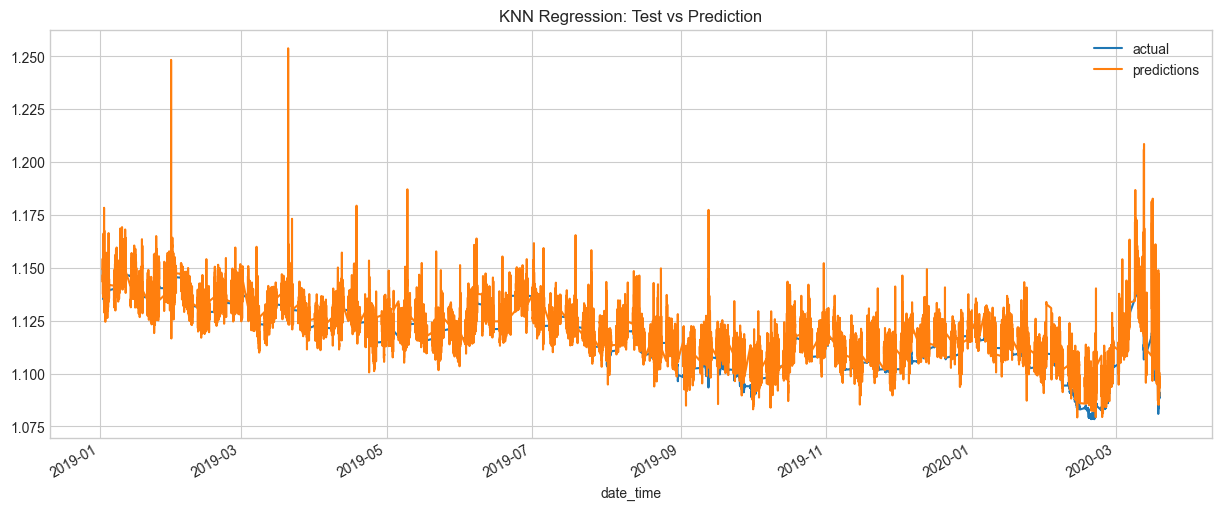

In [10]:
# Tìm k tốt nhất chỉ với 1 lần chạy mỗi k
best_k_value = None
best_rmse = float('inf')

for k in range(50, 501, 50):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_scaled_train, y_train)
    y_pred = knn.predict(X_scaled_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"k={k}, RMSE: {rmse}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_k_value = k

print(f"\nBest k value: {best_k_value} with RMSE: {best_rmse}")

# Huấn luyện mô hình cuối cùng với k tốt nhất
final_knn_model = KNeighborsRegressor(n_neighbors=best_k_value)
final_knn_model.fit(X_scaled_train, y_train)
y_pred_final = final_knn_model.predict(X_scaled_test)

# Đánh giá mô hình
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print(f"\nK Best K = {best_k_value}\n")
print("\nFinal Model Performance (with best k):")
print(f"RMSE: {rmse_final}")
print(f"MAE: {mae_final}")
print(f"R-squared: {r2_final}")

# Vẽ biểu đồ kết quả
test_vs_pred = pd.DataFrame({'actual': y_test, 'predictions': y_pred_final})
test_vs_pred.plot(figsize=(15, 6))
plt.title('KNN Regression: Test vs Prediction')
plt.show()

## 3.2 Bayesian Ridge Regression

Root Mean Squared Error: 0.0004287528807094467
Mean Absolute Error: 0.0002616400734807224
R-Squared: 0.9991543620131212


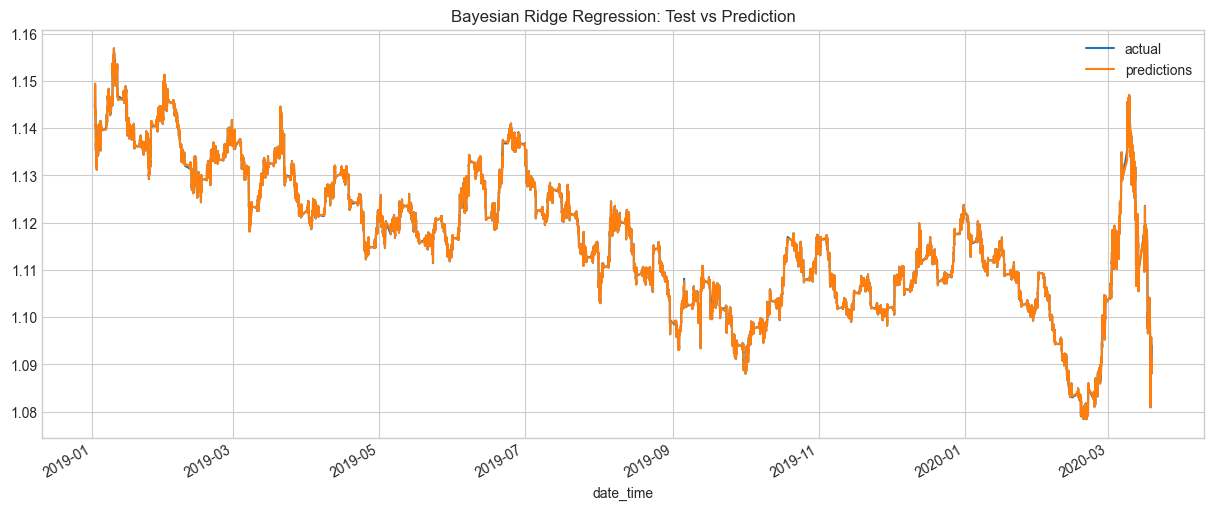

In [11]:
# Bayesian Ridge Regression
bayes_ridge = BayesianRidge()
bayes_ridge.fit(X_scaled_train, y_train)

# predicting the closing price
predictions = bayes_ridge.predict(X_scaled_test)

# model evaluation
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('R-Squared:', r2_score(y_test, predictions))

# plotting the results
test_vs_pred = pd.DataFrame({'actual': y_test, 'predictions': predictions})
test_vs_pred.plot(figsize=(15, 6))
plt.title('Bayesian Ridge Regression: Test vs Prediction')
plt.show()

## 3.3 DecisionTree

Root Mean Squared Error: 0.0008925250630957554
Mean Absolute Error: 0.0005897877083818585
R-Squared: 0.9963355295619103


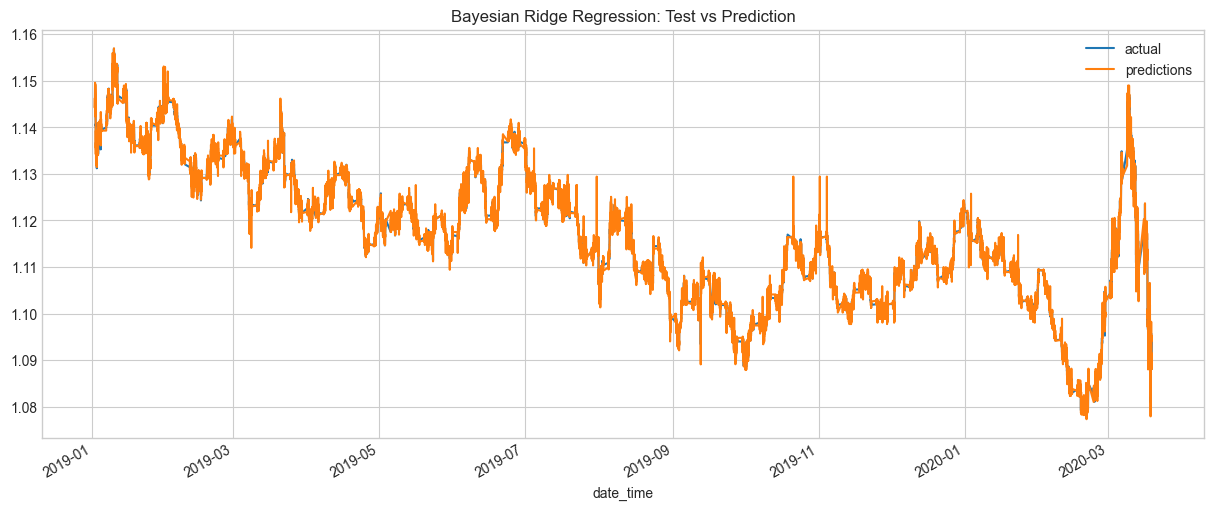

In [12]:
# Bayesian Ridge Regression
bayes_ridge = DecisionTreeRegressor()
bayes_ridge.fit(X_scaled_train, y_train)

# predicting the closing price
predictions = bayes_ridge.predict(X_scaled_test)

# model evaluation
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('R-Squared:', r2_score(y_test, predictions))

# plotting the results
test_vs_pred = pd.DataFrame({'actual': y_test, 'predictions': predictions})
test_vs_pred.plot(figsize=(15, 6))
plt.title('Bayesian Ridge Regression: Test vs Prediction')
plt.show()

## 3.4 Linear Regression

Root Mean Squared Error: 0.00042874536431584677
Mean Absolute Error: 0.0002616387420858142
R-Squared: 0.9991543916623319


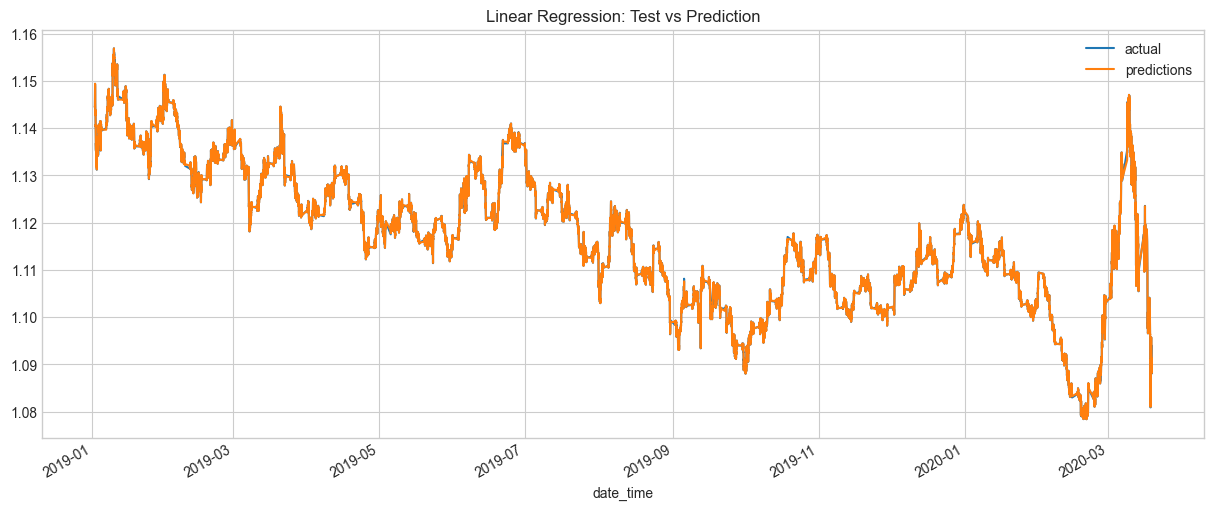

In [13]:
#Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_scaled_train, y_train)
#predicting the closing price
predictions = lin_reg.predict(X_scaled_test)

#model evaluation
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('R-Squared:', r2_score(y_test, predictions))

#plotting the results
test_vs_pred = pd.DataFrame({'actual':y_test, 'predictions':predictions})
test_vs_pred.plot(figsize=(15,6))
plt.title('Linear Regression: Test vs Prediction')
plt.show()

## 3.5 Lasso Regression

Root Mean Squared Error: 0.057656696168151195
Mean Absolute Error: 0.05699602234525794
R-Squared: -14.29219711820274


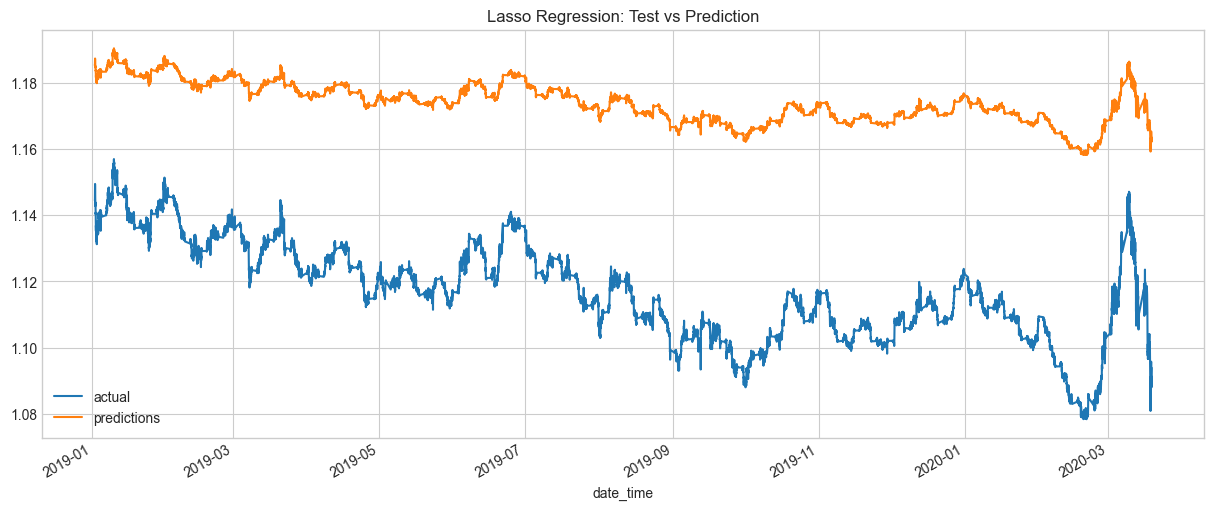

In [14]:
# Lasso Regression
lasso_reg = Lasso(alpha=0.1)  # Có thể thử alpha = 0.01, 0.5, v.v.
lasso_reg.fit(X_scaled_train, y_train)

# Predicting the closing price
predictions = lasso_reg.predict(X_scaled_test)

# Model evaluation
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('R-Squared:', r2_score(y_test, predictions))

# Plotting the results
test_vs_pred = pd.DataFrame({'actual': y_test, 'predictions': predictions})
test_vs_pred.plot(figsize=(15, 6))
plt.title('Lasso Regression: Test vs Prediction')
plt.show()

## 3.6 Ridge Regression

Root Mean Squared Error: 0.0004317421603421091
Mean Absolute Error: 0.00026314408540847585
R-Squared: 0.9991425292738099


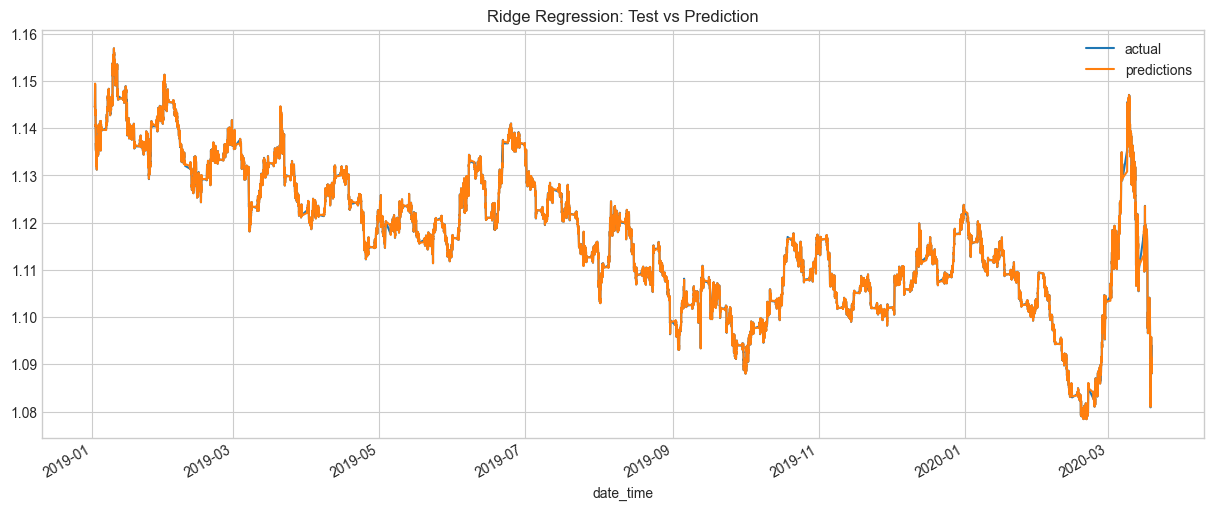

In [15]:
# Ridge Regression
ridge_reg = Ridge(alpha=1.0)  # Bạn có thể thử các giá trị alpha khác như 0.1, 10, v.v.
ridge_reg.fit(X_scaled_train, y_train)

# Predicting the closing price
predictions = ridge_reg.predict(X_scaled_test)

# Model evaluation
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('R-Squared:', r2_score(y_test, predictions))

# Plotting the results
test_vs_pred = pd.DataFrame({'actual': y_test, 'predictions': predictions})
test_vs_pred.plot(figsize=(15, 6))
plt.title('Ridge Regression: Test vs Prediction')
plt.show()

## 3.7 Support Vector Regressor

Root Mean Squared Error: 0.024264902259828837
Mean Absolute Error: 0.02198280120681511
R-Squared: -1.7084914829419042


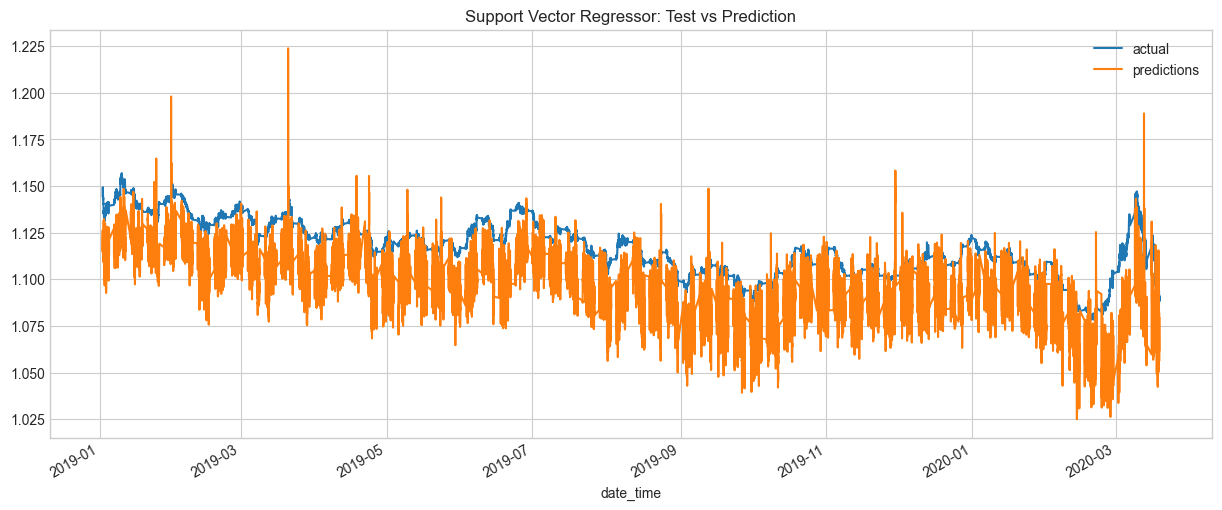

In [16]:
#Support Vector Regressor
svr = SVR()
svr.fit(X_scaled_train, y_train)

#predicting the closing price
predictions = svr.predict(X_scaled_test)

#model evaluation
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('R-Squared:', r2_score(y_test, predictions))

#plotting the results
test_vs_pred = pd.DataFrame({'actual':y_test, 'predictions':predictions})
test_vs_pred.plot(figsize=(15,6))
plt.title('Support Vector Regressor: Test vs Prediction')
plt.show()

## 3.8 Bagging Regressor

Root Mean Squared Error: 0.0004918335339435347
Mean Absolute Error: 0.00031404924466775383
R-Squared: 0.9988872268087055


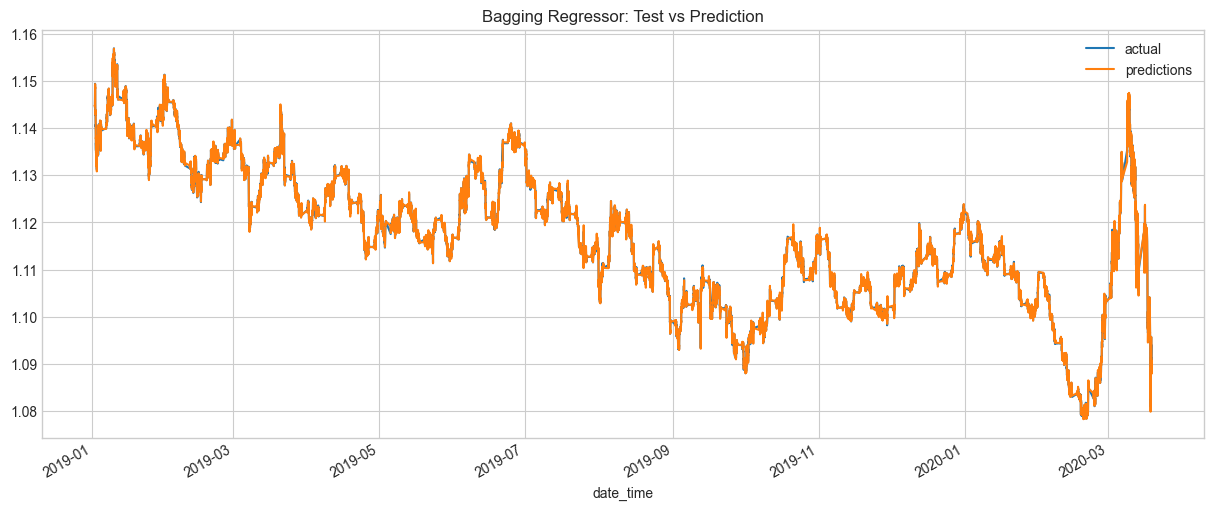

In [24]:
#Bagging Regressor
bag_reg = BaggingRegressor(n_estimators=200, n_jobs=-1, random_state=42)
bag_reg.fit(X_scaled_train, y_train)

#predicting the closing price
predictions = bag_reg.predict(X_scaled_test)

#model evaluation
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('R-Squared:', r2_score(y_test, predictions))

#plotting the results
test_vs_pred = pd.DataFrame({'actual':y_test, 'predictions':predictions})
test_vs_pred.plot(figsize=(15,6))
plt.title('Bagging Regressor: Test vs Prediction')
plt.show()

## 3.9 Random Forest Regressor

Root Mean Squared Error: 0.000491150426350094
Mean Absolute Error: 0.0003134584966559213
R-Squared: 0.9988903157234802


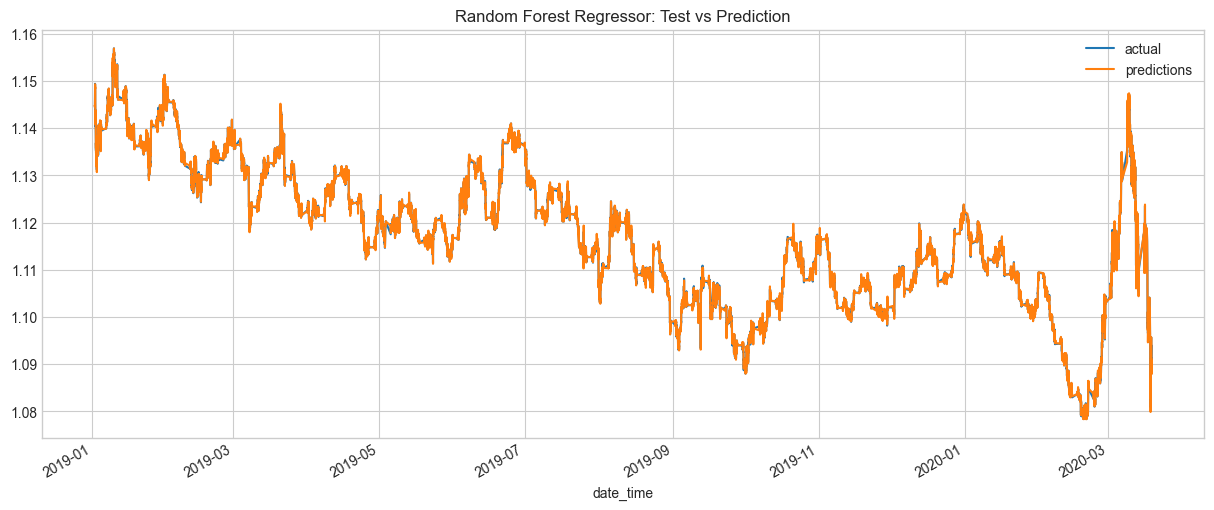

In [25]:
#Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rf_reg.fit(X_scaled_train, y_train)

#predicting the closing price
predictions = rf_reg.predict(X_scaled_test)

#model evaluation
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('R-Squared:', r2_score(y_test, predictions))

#plotting the results
test_vs_pred = pd.DataFrame({'actual':y_test, 'predictions':predictions})
test_vs_pred.plot(figsize=(15,6))
plt.title('Random Forest Regressor: Test vs Prediction')
plt.show()

## 3.10 XGBoost Regressor

Root Mean Squared Error: 0.000605970464341193
Mean Absolute Error: 0.00044623308177764296
R-Squared: 0.9983108302512914


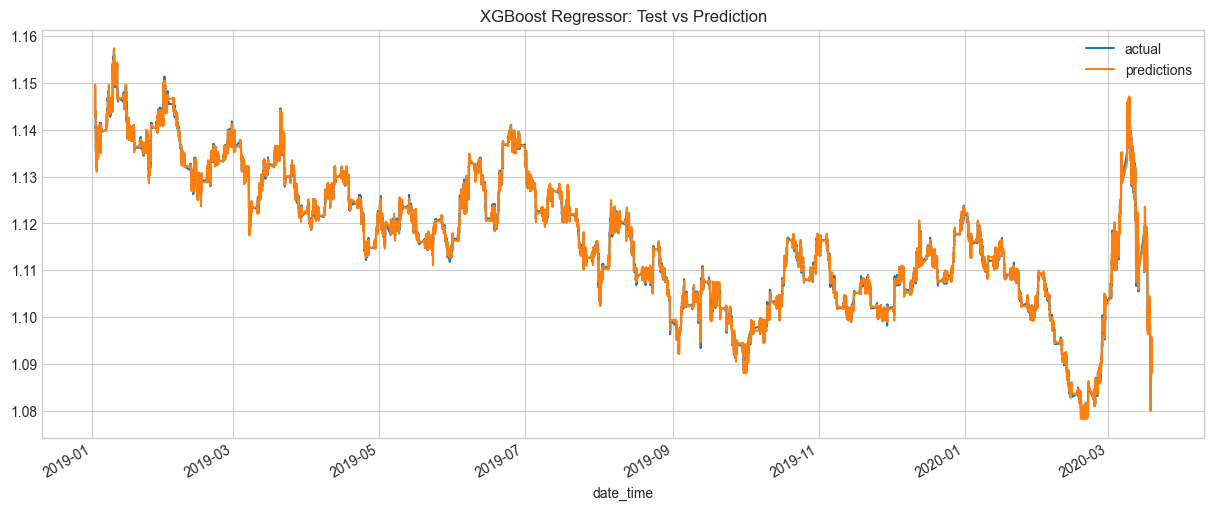

In [21]:
#XGBoost Regressor
xgb_reg = XGBRegressor(n_estimators=500, n_jobs=-1, random_state=42)
xgb_reg.fit(X_scaled_train, y_train)

#predicting the closing price
predictions = xgb_reg.predict(X_scaled_test)

#model evaluation
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('R-Squared:', r2_score(y_test, predictions))

#plotting the results
test_vs_pred = pd.DataFrame({'actual':y_test, 'predictions':predictions})
test_vs_pred.plot(figsize=(15,6))
plt.title('XGBoost Regressor: Test vs Prediction')
plt.show()

## 3.11 Neuron Network

Iteration 1, loss = 0.01076640
Validation score: 0.956727
Iteration 2, loss = 0.00030066
Validation score: 0.992238
Iteration 3, loss = 0.00007705
Validation score: 0.998207
Iteration 4, loss = 0.00003851
Validation score: 0.998505
Iteration 5, loss = 0.00002843
Validation score: 0.999229
Iteration 6, loss = 0.00002478
Validation score: 0.999242
Iteration 7, loss = 0.00001888
Validation score: 0.997394
Iteration 8, loss = 0.00001396
Validation score: 0.999875
Iteration 9, loss = 0.00001014
Validation score: 0.999933
Iteration 10, loss = 0.00000802
Validation score: 0.999921
Iteration 11, loss = 0.00000557
Validation score: 0.999941
Iteration 12, loss = 0.00000420
Validation score: 0.999946
Iteration 13, loss = 0.00000363
Validation score: 0.999945
Iteration 14, loss = 0.00000283
Validation score: 0.999936
Iteration 15, loss = 0.00000239
Validation score: 0.999866
Iteration 16, loss = 0.00000212
Validation score: 0.999959
Iteration 17, loss = 0.00000193
Validation score: 0.999892
Iterat

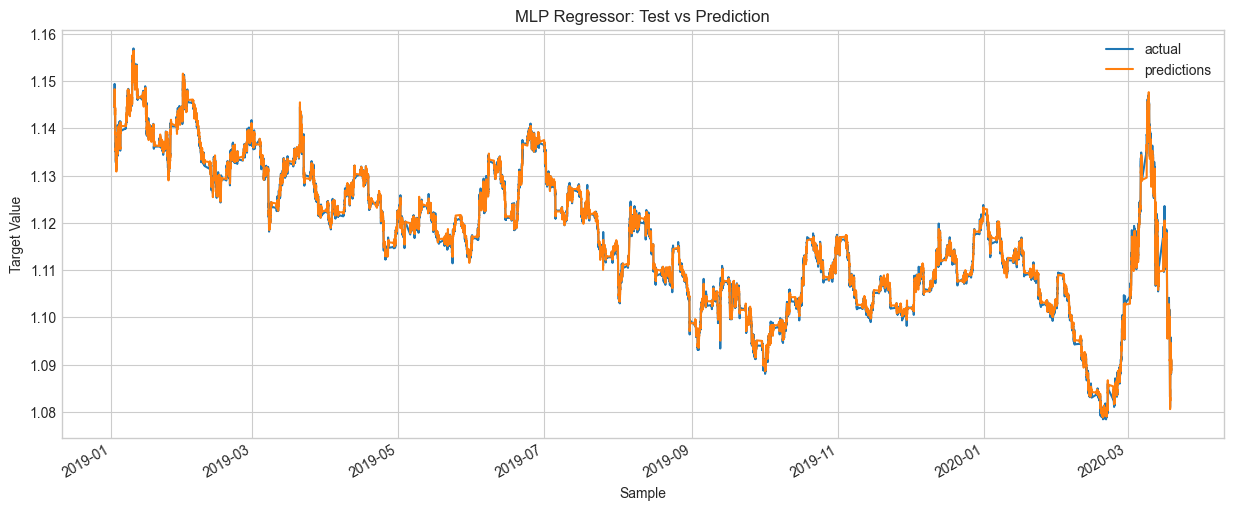

In [22]:
mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32),
                         activation='relu',
                         solver='adam',
                         max_iter=200,             # Số epoch tương đương
                         random_state=42,
                         early_stopping=True,      # Dừng sớm nếu không cải thiện trên tập validation
                         validation_fraction=0.2,  # Dùng 20% tập train làm validation
                         verbose=True)             # In quá trình train

# Huấn luyện mô hình
mlp_model.fit(X_scaled_train, y_train)

# Dự đoán trên tập test
predictions_nn = mlp_model.predict(X_scaled_test)

# Đánh giá mô hình
rmse_nn = np.sqrt(mean_squared_error(y_test, predictions_nn))
mae_nn = mean_absolute_error(y_test, predictions_nn)
r2_nn = r2_score(y_test, predictions_nn)

print('\nMLP Regressor Evaluation:')
print('Root Mean Squared Error:', rmse_nn)
print('Mean Absolute Error:', mae_nn)
print('R-Squared:', r2_nn)

# Biểu đồ kết quả thực tế vs dự đoán
test_vs_pred_nn = pd.DataFrame({'actual': y_test, 'predictions': predictions_nn})
test_vs_pred_nn.plot(figsize=(15, 6))
plt.title('MLP Regressor: Test vs Prediction')
plt.xlabel('Sample')
plt.ylabel('Target Value')
plt.show()